# Projeto de Classificação para Marinha do Brasil

## Autor: Natanael Junior (natmourajr@gmail.com)

Laboratório de Processamento de Sinais - UFRJ

Laboratório de Tecnologia Sonar

Instituto de Pesquisas da Marinha - IPqM

In [8]:
import os
import pickle
import numpy as np
import time

from keras.utils import np_utils
from keras.models import load_model

import sklearn.metrics
from sklearn.externals import joblib
from sklearn import preprocessing

from Functions import TrainParameters as trnparams
from Functions import TrainFunctions

import multiprocessing 

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'NeuralNetwork'

# Enviroment variables
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

# paths to export results
base_results_path = '%s/%s'%(results_path,analysis_name)
pict_results_path = '%s/pictures_files'%(base_results_path)
files_results_path = '%s/output_files'%(base_results_path)

# For multiprocessing
num_processes = multiprocessing.cpu_count()

# Read data
m_time = time.time()

# Database caracteristics
database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = False
development_events = 100

# Check if LofarData has created...
if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
    
    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)

    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:], 
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)
        
    all_data = balanced_data
    all_trgt = balanced_trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Time to import all libraries: 4.88758087158e-05 seconds
Time to read data file: 0.946126937866 seconds
Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


In [9]:
%time 
# Load train parameters

analysis_str = 'NeuralNetwork'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NNNoveltyDetectionTrnParams(n_inits=1,
                                                       hidden_activation='softplus',
                                                       output_activation='softmax',
                                                       n_epochs=500,
                                                       patience=30,
                                                       batch_size=240,
                                                       verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NNNoveltyDetectionTrnParams()
    trn_params.load(trn_params_folder)
    
# Choose how many fold to be used in Cross Validation
n_folds = 2
CVO = trnparams.NoveltyDetectionFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)
print trn_params.get_params_str()

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 5.96 µs
1_inits_mapstd_norm_500_epochs_240_batch_size_softplus_hidden_activation_softmax_output_activation


# Treinamento com Processamento Pararalelo

In [3]:
# Train range of neurons

# Choose neurons topology
max_n_neurons = 500
min_n_neurons = 0
neurons_step = 50

verbose = False

# Create neurons vector to be used in multiprocessing.Pool()
neurons_mat = range(min_n_neurons, max_n_neurons, neurons_step)
start_time = time.time()
print trn_params.get_params_str()
for inovelty, novelty_class in enumerate(np.unique(trgt)):
    trn_data = all_data[all_trgt!=novelty_class]
    trn_trgt = all_trgt[all_trgt!=novelty_class]

    trn_trgt[trn_trgt>novelty_class] = trn_trgt[trn_trgt>novelty_class]-1
    
    if inovelty != 0:
        print ''
    print 'Novelty class: %i'%inovelty
    
    def trainNeuron(ineuron):
        n_folds = len(CVO[inovelty])
        for ifold in range(n_folds):
            #print 'Neuron value: %i - fold %i'%(ineuron, ifold)
            TrainFunctions.NNNoveltyTrainFunction(data=trn_data,
                                                       trgt=trn_trgt,
                                                       inovelty=inovelty,
                                                       ifold=ifold,
                                                       n_folds=n_folds,
                                                       n_neurons=ineuron,
                                                       trn_params=trn_params,
                                                       save_path=results_path,
                                                       verbose=verbose,
                                                       dev=development_flag)
    
    
    # Start Parallel processing
    p = multiprocessing.Pool(processes=num_processes)
    
    # To train on multiple cores sweeping the number of neurons
    results = p.map(trainNeuron, neurons_mat)
            
    p.close()
    p.join()        

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

1_inits_mapstd_norm_500_epochs_240_batch_size_softplus_hidden_activation_softmax_output_activation
Novelty class: 0

Novelty class: 1

Novelty class: 2

Novelty class: 3
It took 14.311 seconds to perform the training


Novelty class: 0 - neuron: 20 - fold 0
Novelty class: 0 - neuron: 20 - fold 1
Novelty class: 1 - neuron: 20 - fold 0
Novelty class: 1 - neuron: 20 - fold 1
Novelty class: 2 - neuron: 20 - fold 0
Novelty class: 2 - neuron: 20 - fold 1
Novelty class: 3 - neuron: 20 - fold 0
Novelty class: 3 - neuron: 20 - fold 1
1_inits_mapstd_norm_500_epochs_240_batch_size_softplus_hidden_activation_softmax_output_activation


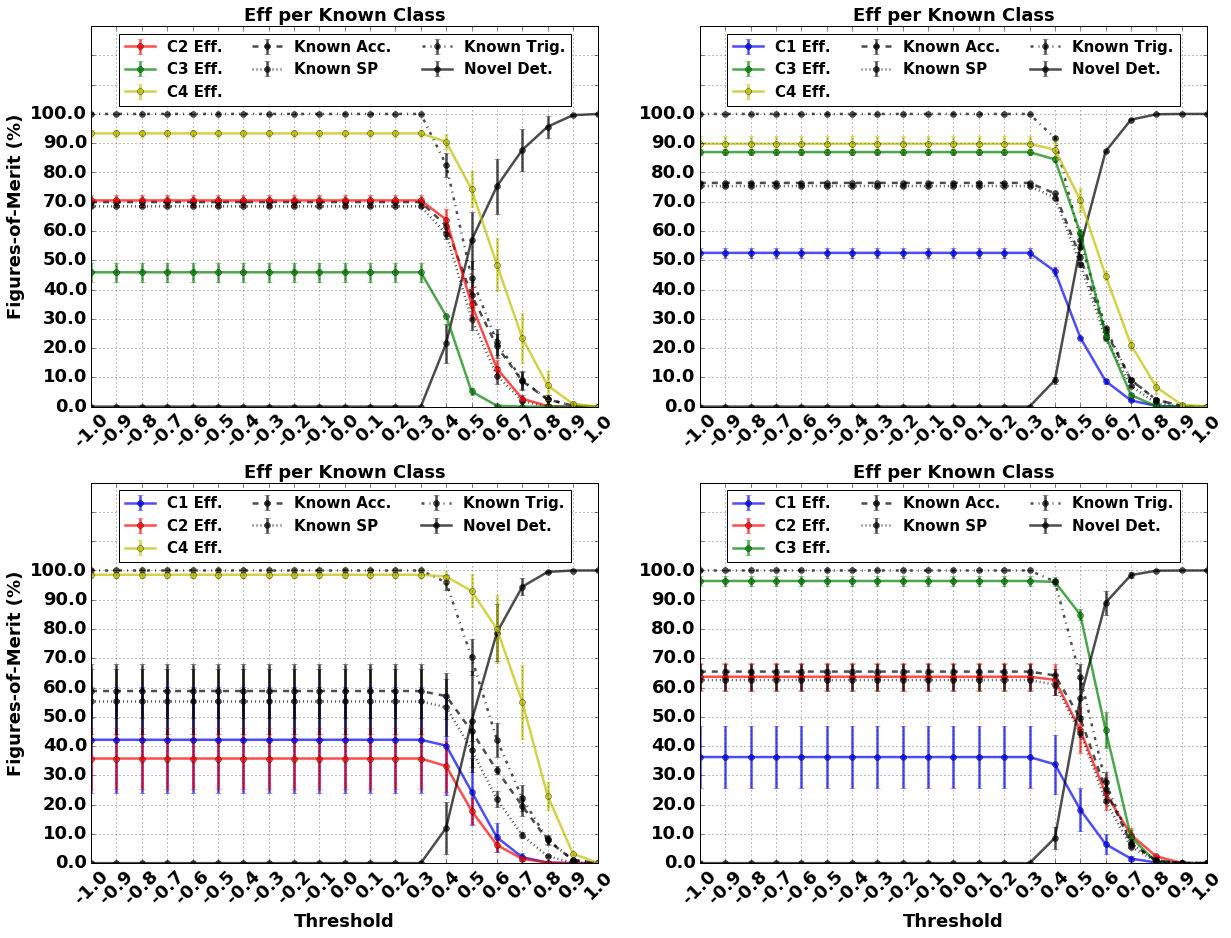

In [10]:
# analysis example - novelty detection for neural network
# thr. sweep

from sklearn import preprocessing
from Functions import TrainParameters as trnparams
from Functions import FunctionsDataVisualization

ineuron = 20

# generate analysis data
save_path=results_path

analysis_str = 'NeuralNetwork'
model_prefix_str = 'RawData'

current_analysis = 'figures_of_merit'

analysis_file_name='%s/%s/%s_novelty_detection_thr_sweep.jbl'%(results_path,analysis_str,analysis_name)

if os.path.exists(analysis_file_name):
        os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
    
    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NNNoveltyDetectionTrnParams(n_epochs=30,n_inits=1)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NNNoveltyDetectionTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
    n_folds = 2
    CVO = trnparams.NoveltyDetectionFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

    thr_mat = np.round(np.arange(-1.0,1.1,0.1),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    
    for inovelty, novelty_class in enumerate(np.unique(trgt)):
        trn_data = all_data[all_trgt!=novelty_class]
        trn_trgt = all_trgt[all_trgt!=novelty_class]
        # trgt max = 2
        trn_trgt[trn_trgt>novelty_class] = trn_trgt[trn_trgt>novelty_class]-1
        
        for ifold in range(len(CVO[inovelty])):
            print 'Novelty class: %01.0f - neuron: %i - fold %i'%(novelty_class, ineuron, ifold)
            [classifier,trn_desc] = TrainFunctions.NNNoveltyTrainFunction(data=trn_data,
                                                           trgt=trn_trgt, 
                                                           inovelty=inovelty, 
                                                           ifold=ifold, 
                                                           n_folds=len(CVO[inovelty]), 
                                                           n_neurons=ineuron, 
                                                           trn_params=trn_params, 
                                                           save_path=results_path, 
                                                           dev=development_flag)
            
            output = classifier.predict(trn_data)
            novelty_output = classifier.predict(all_data[all_trgt==novelty_class])
            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(trgt))-1])
                for iclass, class_id in enumerate(np.unique(trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[trn_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, inovelty, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, inovelty, iclass, ithr]
                novelty_eff_mat[ifold, inovelty, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, inovelty, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, inovelty, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, inovelty, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))
    joblib.dump([class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat],
                analysis_file_name,compress=9)
else:
    print 'file exists'
    [class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.subplots(figsize=(20,15))

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

m_colors = ['b', 'r', 'g', 'y']

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    ax = plt.subplot(2,2,inovelty+1)
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        if novelty_class == m_class:
            #a = 0
            ax.errorbar(thr_mat,np.mean(novelty_eff_mat[:,int(novelty_class),:],axis=0),
                        np.std(novelty_eff_mat[:,int(novelty_class),:],axis=0),fmt='o-',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Novel Det.')
            ax.errorbar(thr_mat,np.mean(known_acc_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_acc_mat[:,int(novelty_class),:],axis=0),fmt='o--',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Acc.')
            ax.errorbar(thr_mat,np.mean(known_sp_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_sp_mat[:,int(novelty_class),:],axis=0),fmt='o:',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known SP')
            ax.errorbar(thr_mat,np.mean(known_trig_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_trig_mat[:,int(novelty_class),:],axis=0),fmt='o-.',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Trig.')
        else:
            ax.errorbar(thr_mat,np.mean(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),
                        np.std(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),fmt='o-',
                        color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                       label='C%i Eff.'%(int(m_class)+1))
    ax.set_xticks(thr_mat)
    ax.set_xticklabels(thr_mat,rotation=45, fontsize=18)
    ax.set_title('Eff per Known Class',fontsize=18,weight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])
    
    ax.set_ylim([0.0, 1.3])
    y_ticks = np.arange(0.0,1.3,0.1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(100*y_ticks[y_ticks<=1.0],fontsize=18)
    
    ax.grid()
    
    if inovelty > 1:
        ax.set_xlabel('Threshold',fontsize=18,weight='bold')
    if inovelty == 0 or inovelty == 2:
        ax.set_ylabel('Figures-of-Merit (%)',fontsize=18,weight='bold')
        
    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3, loc='upper center')
    
#     rect = [0.1, 0.1, 0.5, 0.4]
#     ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
#     a = thr_mat>=0.4 
#     b = thr_mat<=0.7
#     selected_thr = a & b
#     for iclass, m_class in enumerate(np.unique(all_trgt)):
#         if novelty_class == m_class:
#             #a = 0
#             ax1.errorbar(thr_mat[selected_thr],np.mean(novelty_eff_mat[:,int(novelty_class),selected_thr],axis=0),
#                         np.std(novelty_eff_mat[:,int(novelty_class),selected_thr],axis=0),fmt='o-',
#                         color='k',alpha=0.7,linewidth=2.5,
#                         label='Novel Det.')
#         else:
#             ax1.errorbar(thr_mat[selected_thr],np.mean(class_eff_mat[:,int(novelty_class),int(m_class),selected_thr],axis=0),
#                         np.std(class_eff_mat[:,int(novelty_class),int(m_class),selected_thr],axis=0),fmt='o-',
#                         color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
#                        label='C%i Eff.'%(int(m_class)+1))
#     ax1.set_xticks(thr_mat[selected_thr])
#     ax1.set_xticklabels(thr_mat[selected_thr],rotation=45, fontsize=12)
    
#     ax1.set_yticklabels(100.*ax1.get_yticks(), fontsize=12)
    
#     ax1.grid()
    #Save the figure
    file_name = pict_results_path+'/'+current_analysis+'_%s_neurons_%i_fold_'%(ineuron,ifold)+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print trn_params.get_params_str()